In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  #
])

In [ ]:
# Load Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.64MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.3MB/s]


In [ ]:
print(train_dataset.classes)
print(train_dataset.class_to_idx)
print(train_dataset.targets)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
tensor([9, 0, 0,  ..., 3, 0, 5])


In [ ]:
image, label = train_dataset[0]
print(image.shape)
print(len(train_dataset))

torch.Size([1, 28, 28])
60000


In [ ]:
image, label = test_dataset[0]
print(image.shape)
print(len(test_dataset))

torch.Size([1, 28, 28])
10000


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class CNNClassifier (nn.Module):
  def __init__(self):
    super (CNNClassifier, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn. Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.pool = nn. MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn. Linear (128 * 3 * 3, 128)
    self.fc2 = nn. Linear (128, 64)
    self.fc3= nn. Linear (64, 10)
  def forward(self, x):
    x = self.pool (torch.relu(self.conv1(x)))
    x = self.pool (torch.relu(self.conv2(x)))
    x = self.pool(torch.relu(self.conv3(x)))
    x = x.view(x.size (0), -1) # Flatten the image
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
from torchsummary import summary

# Initialize model
model = CNNClassifier()

# Move model to GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)

# Print model summary

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]          73,856
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Linear-7                  [-1, 128]         147,584
            Linear-8                   [-1, 64]           8,256
            Linear-9                   [-1, 10]             650
Total params: 249,162
Trainable params: 249,162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 0.95
Estimated Total Size (MB): 1.37
-------------------------------------------

In [ ]:
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

In [ ]:
train_model(model, train_loader,criterion,optimizer)

Epoch [3/3], Loss: 0.2438


In [ ]:
## Step 4: Test the Model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total

    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

Test Accuracy: 0.9069


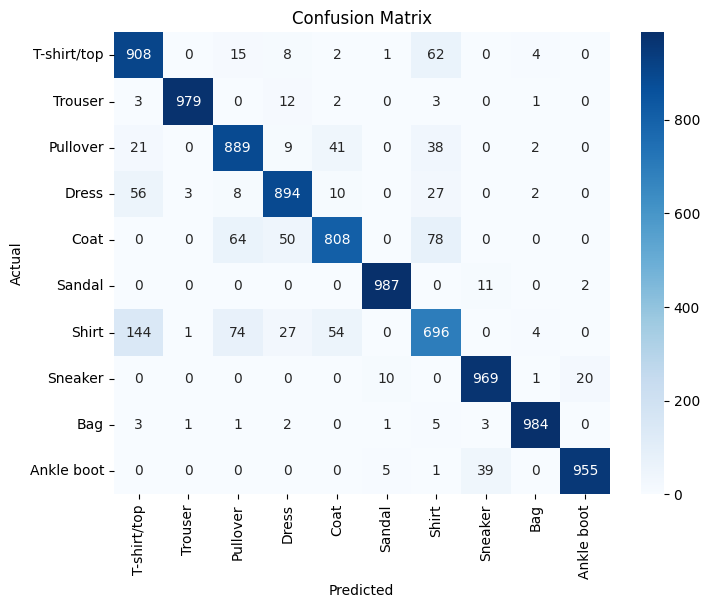

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.91      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.85      0.89      0.87      1000
       Dress       0.89      0.89      0.89      1000
        Coat       0.88      0.81      0.84      1000
      Sandal       0.98      0.99      0.99      1000
       Shirt       0.76      0.70      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
# Evaluate the model
test_model(model, test_loader)

In [ ]:
import matplotlib.pyplot as plt
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Add batch dimension
        _, predicted = torch.max(output, 1)
    class_names = dataset.classes

    # Display the image
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()
    print(f'Actual: {class_names[label]}, Predicted: {class_names[predicted.item()]}')

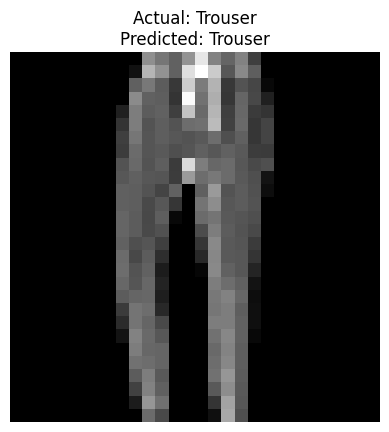

Actual: Trouser, Predicted: Trouser


In [ ]:
predict_image(model, image_index=80, dataset=test_dataset)